## Loading data

In [160]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, SGDRegressor, RidgeCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import catboost as cb
import xgboost as xgb
from tpot import TPOTRegressor
from tpot.builtins import StackingEstimator
import datetime as dt

# Load the data from a csv named 'jobs_dataset_without_solution.xlsx'

X_train_data = pd.read_excel('jobs_dataset_without_solution.xlsx', sheet_name='X_train')              
X_test_data = pd.read_excel('jobs_dataset_without_solution.xlsx', sheet_name='X_test')
y_train_data = pd.read_excel('jobs_dataset_without_solution.xlsx', sheet_name='y_train')
jobs = pd.read_csv('jobs_in_data_2024.csv')

X_train_data['works_abroad'] = X_train_data['employee_residence'] != X_train_data['company_location']
X_train_data['works_abroad'] = X_train_data['works_abroad'].astype(int)   
X_train_data['job_title'] = X_train_data['job_title'].str.replace(r'\bBI\b', 'Business Intelligence', regex=True)
X_train_data['job_title'] = X_train_data['job_title'].str.replace(r'\bML\b', 'Machine Learning', regex=True)


def replace_outliers(data, column_name='job_title', threshold=10):
    """
    Replaces job titles with counts less than the specified threshold with 'Other'.

    Parameters:
    data (pd.DataFrame): The DataFrame containing job titles.
    column_name (str): The name of the column containing job titles.
    threshold (int): The count threshold below which job titles are replaced with 'Other'.

    Returns:
    pd.DataFrame: The DataFrame with job titles modified.
    """
    # Calculate the value counts of the job titles
    value_counts = data[column_name].value_counts()

    # Identify job titles with counts below the threshold
    to_replace = value_counts[value_counts < threshold].index

    # Replace rare job titles with 'Other'
    data[column_name] = data[column_name].apply(lambda x: 'Other' if x in to_replace else x)

    return data

# Now use the function to replace rare job titles
X_train_data = replace_outliers(X_train_data, 'job_title', 100)
X_train_data = replace_outliers(X_train_data, 'company_location', 20)

print(X_train_data['company_location'].value_counts())
print(X_train_data['job_title'].value_counts())

X_train_data.columns

company_location
United States     11248
United Kingdom      554
Canada              328
Other               302
Spain               113
Germany              83
France               52
Australia            45
Netherlands          28
Portugal             26
Name: count, dtype: int64
job_title
Data Engineer                      2755
Data Scientist                     2632
Data Analyst                       1893
Other                              1571
Machine Learning Engineer          1487
Research Scientist                  410
Analytics Engineer                  354
Applied Scientist                   339
Data Architect                      310
Research Engineer                   233
Business Intelligence Engineer      187
Data Manager                        170
Data Science                        167
Business Intelligence Analyst       150
Business Intelligence Developer     121
Name: count, dtype: int64


Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'work_setting', 'company_location',
       'company_size', 'job_category', 'works_abroad'],
      dtype='object')

## Visualise distribution of target variable

<Axes: ylabel='Count'>

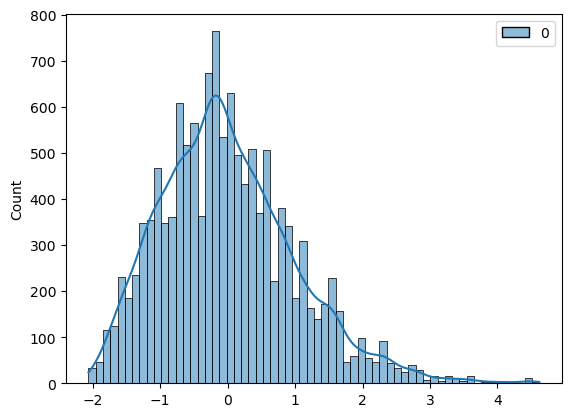

In [156]:
y_scaled = StandardScaler().fit_transform(y_train_data)

sns.histplot(y_scaled, kde=True)

## Visualizing train distribution

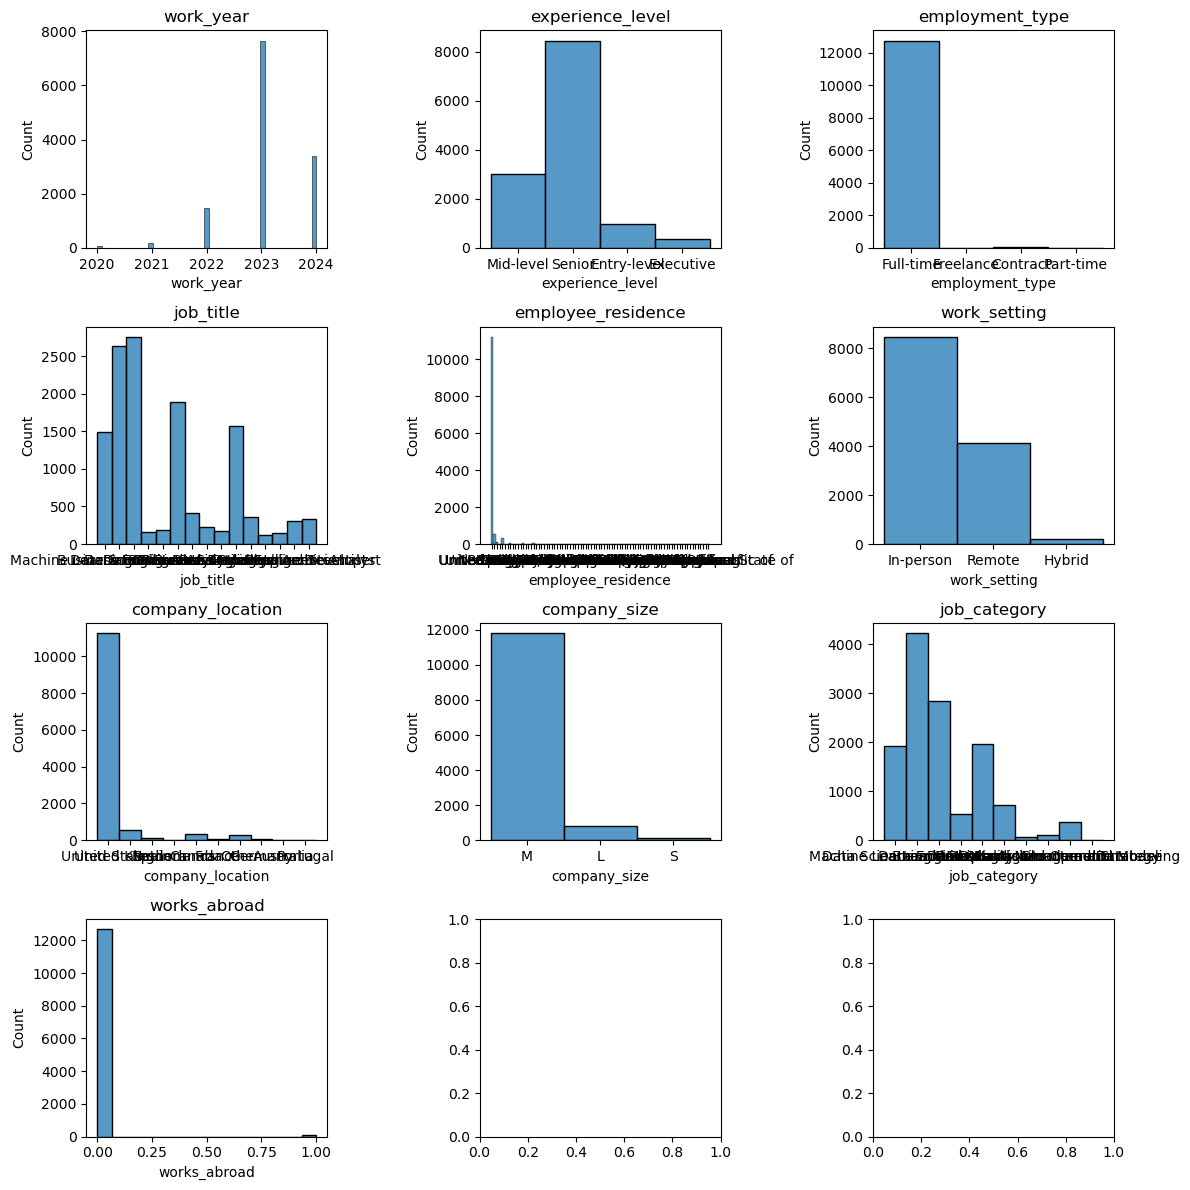

In [113]:
fig, ax = plt.subplots(4, 3, figsize=(12, 12))

for i, col in enumerate(X_train_data.columns):
    sns.histplot(X_train_data[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(col)
    plt.tight_layout()
    

## Visualizing test distribution

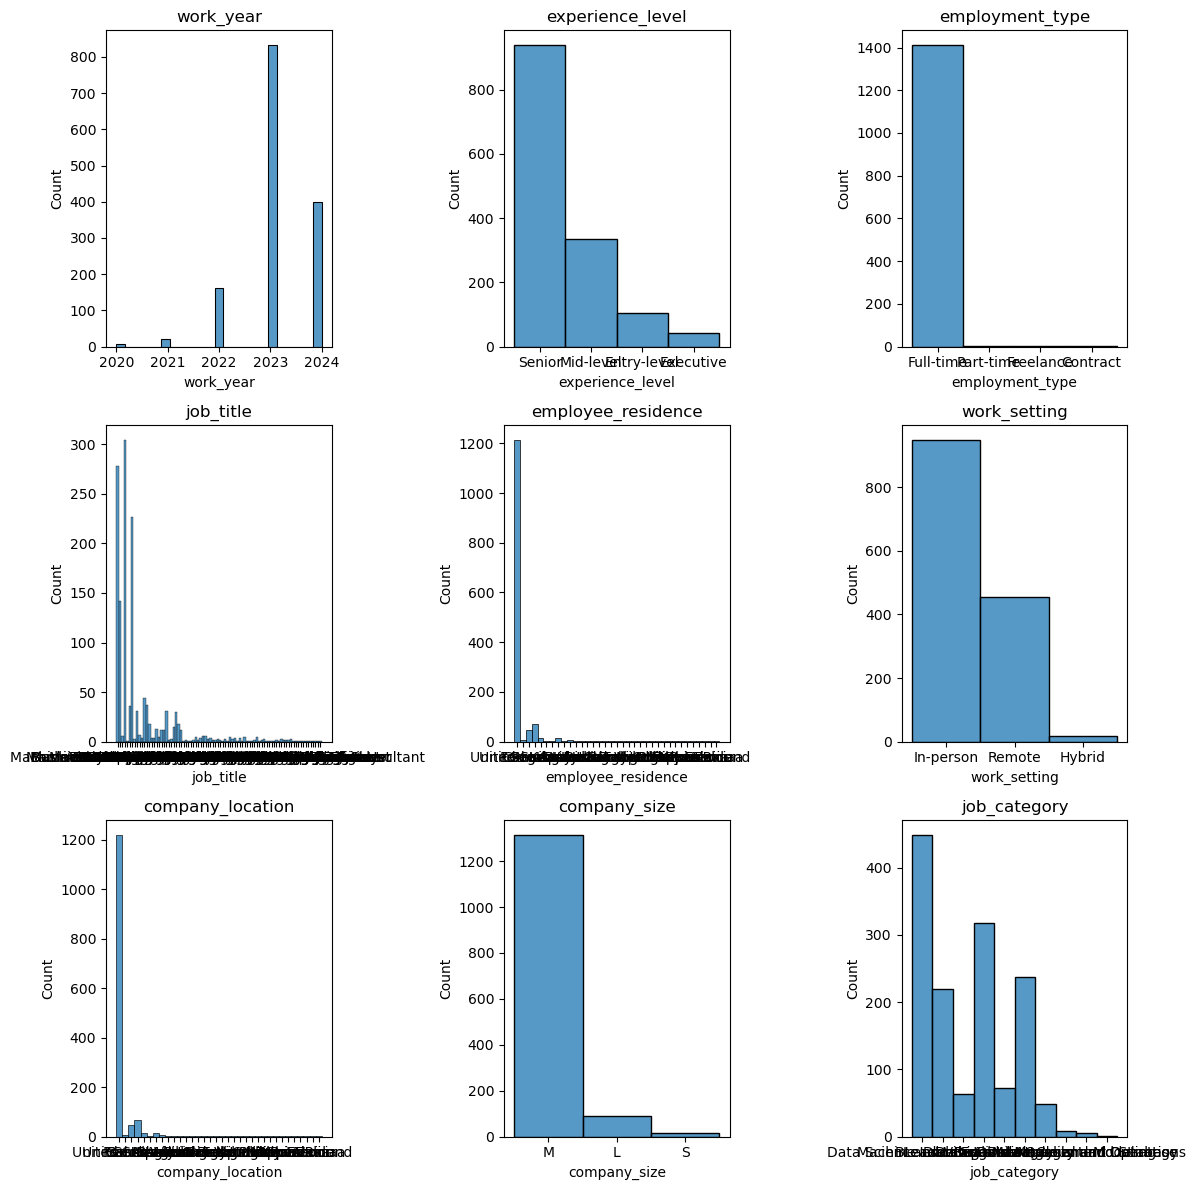

In [114]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i, col in enumerate(X_test_data.columns):
    sns.histplot(X_test_data[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(col)
    plt.tight_layout()
    

## Preprocessing


In [115]:
# Define columns by data type for selective preprocessing
label_features = ['employment_type', 'work_setting']

ohe_features = ['company_location', 'job_title', 'job_category']


# Define the preprocessing for categorical data
ordinal_features = ['work_year', 'experience_level', 'company_size']
ordinal_categories = [['2020', '2021', '2022', '2023', '2024'],
                      ['Entry-level', 'Mid-level', 'Senior', 'Executive'],
                      ['S', 'M', 'L']]
# Create a OneHotEncoder with predefined categories
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), ohe_features), 
        ('ord1', make_pipeline(OrdinalEncoder(), StandardScaler()), label_features),
        ('ord2', make_pipeline(OrdinalEncoder(categories=ordinal_categories), StandardScaler()), ordinal_features)
    ])

# Fitting the transformer and transforming the X_train_data
X_transformed = preprocessor.fit_transform(X_train_data)

# Extracting new feature names from the transformed columns
ohe_columns = list(preprocessor.named_transformers_['ohe'].get_feature_names_out(ohe_features))
ord1_columns = label_features
ord2_columns = ordinal_features

new_columns = ohe_columns + ord1_columns + ord2_columns 

# Create a DataFrame from the transformed data
X_train_encoded = pd.DataFrame(X_transformed, columns=new_columns)

X_train_encoded.head()

,company_location_Australia,company_location_Canada,company_location_France,company_location_Germany,company_location_Netherlands,company_location_Other,company_location_Portugal,company_location_Spain,company_location_United Kingdom,company_location_United States,...,job_category_Data Management and Strategy,job_category_Data Quality and Operations,job_category_Data Science and Research,job_category_Leadership and Management,job_category_Machine Learning and AI,employment_type,work_setting,work_year,experience_level,company_size
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.030018,-0.622537,-0.158284,-0.974174,-0.195008
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.030018,-0.622537,-0.158284,-0.974174,-0.195008
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.030018,-0.622537,1.297956,0.537724,-0.195008
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.030018,1.404833,1.297956,0.537724,-0.195008
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.030018,1.404833,1.297956,0.537724,-0.195008


## Using RandomForestRegression

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
import numpy as np

# Assuming X_train_encoded and y_train_data are defined and preprocessed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data.values, test_size=0.20, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Define the model and scaler within a TransformedTargetRegressor
transformed_target_rf = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=42),
    transformer=StandardScaler()
)

# Create a pipeline
pipeline = Pipeline([
    ('regressor', transformed_target_rf)
])

# Set up KFold cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Cross-validated RMSE:", np.sqrt(-scores).mean())

# Define the hyperparameter grid
param_grid = {
    'regressor__regressor__n_estimators': [100, 200, 500],
    'regressor__regressor__max_depth': [10, 15, 20],
    'regressor__regressor__min_samples_split': [10, 20, 30, 40],
    'regressor__regressor__min_samples_leaf': [1, 2, 4],
    'regressor__regressor__max_features': ['sqrt'],
    'regressor__regressor__bootstrap': [False]
    
}

# Perform a grid search
gs = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
best_params = gs.best_params_

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Prepare metrics
metrics = {
    "RMSE Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "MAE Train": mean_absolute_error(y_train, y_train_pred),
    "MAE Test": mean_absolute_error(y_test, y_test_pred),
    "R^2 Train": r2_score(y_train, y_train_pred),
    "R^2 Test": r2_score(y_test, y_test_pred),
    "MAPE Test": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

# Convert dictionary to DataFrame for better visualization
results_df = pd.DataFrame([metrics], index=["RandomForestRegressor"])

print("Best parameters found:", best_params)
results_df


Cross-validated RMSE: 48463.9099049825
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters found: {'regressor__regressor__bootstrap': False, 'regressor__regressor__max_depth': 20, 'regressor__regressor__max_features': 'sqrt', 'regressor__regressor__min_samples_leaf': 2, 'regressor__regressor__min_samples_split': 30, 'regressor__regressor__n_estimators': 500}


,RMSE Train,RMSE Test,MAE Train,MAE Test,R^2 Train,R^2 Test,MAPE Test
RandomForestRegressor,46143.859139,48478.712611,35403.866535,36636.717539,0.401613,0.358217,30.424984


## Using a pipeline and testing multiple models with GridSearchCV

In [170]:
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from xgboost import XGBRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data.values, test_size=0.20, random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()
SEED = 42
# Model setup
models = {
    'LinearRegressor': LinearRegression(), 
    'Lasso': Lasso(random_state=SEED, max_iter=10000, tol=0.01),
    'XGBoost': XGBRegressor(random_state=SEED),
    'SGDRegressor': SGDRegressor(random_state=SEED),
    'GradientBoostRegressor':GradientBoostingRegressor(random_state=SEED),
    'RandomForestRegressor':RandomForestRegressor(random_state=SEED),
    'DecisionTreeRegressor':DecisionTreeRegressor(random_state=SEED)
    
}

# Hyperparameter grids

param_grids = {
    'LinearRegressor':{},
    'Lasso': {
        'regressor__alpha': [0.01, 0.1, 1, 10],  # Regularization strength
        'regressor__selection': ['cyclic', 'random'],  # Algorithm used in the fitting process
    },
    'XGBoost': {
        'regressor__n_estimators': [50, 100, 200, 300],  # Number of gradient boosted trees
        'regressor__max_depth': [3, 5, 7, 10],  # Maximum tree depth
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    },
    'SGDRegressor': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization factor
        'regressor__penalty': ['l2', 'l1', 'elasticnet'],  # Penalty (regularization term)
        'regressor__max_iter': [1000, 2000],  # Maximum number of iterations
        'regressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
        'regressor__eta0': [0.01, 0.1]  # Initial learning rate (used when learning_rate is 'constant' or 'adaptive')
    },
    'GradientBoostRegressor': {
        'regressor__n_estimators': [100, 200, 300, 500],  # Number of boosting stages
        'regressor__learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
        'regressor__max_depth': [3, 5, 8]  # Maximum depth of the individual regression estimators
    },
    'RandomForestRegressor': {
        'regressor__n_estimators': [50, 100, 200],  # Number of trees in the forest
        'regressor__max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
        'regressor__max_depth': [None, 10, 20, 30]  # Maximum depth of the tree
    },
    'DecisionTreeRegressor': {
        'regressor__max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
        'regressor__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'regressor__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at a leaf node
    }
}


# Storage for results
results = []

# Set up KFold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():

    # Wrap the model with TransformedTargetRegressor to scale target variable
    pipeline = Pipeline([
        ('regressor', model)
    ])
    
    
    param_grid = param_grids[name]
    gs = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    # Store results
    results.append({
        'Model': name,
        'Best Parameters': gs.best_params_,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R^2 Train': r2_train,
        'R^2 Test': r2_test,
        'MAPE Test': mape_test
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+12, tolerance: 2.920e+11
  model = cd_fast.enet_coordinate_descent(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+12, tolerance: 2.876e+11
  model = cd_fast.enet_coordinate_descent(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improv

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gayk/anaconda3/envs/ds_venv/lib/python3.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,Model,Best Parameters,RMSE Train,RMSE Test,R^2 Train,R^2 Test,MAPE Test
0,LinearRegressor,{},47975.470086,48990.257023,0.353166,0.344602,30.883168
1,Lasso,"{'regressor__alpha': 10, 'regressor__selection...",47974.787473,49002.866680,0.353184,0.344264,30.849828
2,XGBoost,"{'regressor__learning_rate': 0.05, 'regressor_...",46307.670474,48597.279889,0.397357,0.355074,29.974110
3,SGDRegressor,"{'regressor__alpha': 0.1, 'regressor__eta0': 0...",48062.410233,49125.448868,0.350819,0.340979,31.004912
4,GradientBoostRegressor,"{'regressor__learning_rate': 0.1, 'regressor__...",46031.219860,48650.572843,0.404531,0.353659,29.922545
5,RandomForestRegressor,"{'regressor__max_depth': 10, 'regressor__max_f...",46890.888516,49122.281410,0.382081,0.341064,31.445910
6,DecisionTreeRegressor,"{'regressor__max_depth': 10, 'regressor__min_s...",46303.454611,49426.565645,0.397466,0.332876,30.381880


## Using LinearRegession

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data.values, test_size=0.20, random_state=42)

# Create the Linear Regression model
regressor_lr = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(regressor_lr, X_train_encoded, y_train_data.values, cv=kf, scoring='neg_mean_squared_error')



# Fit the model
regressor_lr.fit(X_train, y_train)

# Make predictions
y_train_pred = regressor_lr.predict(X_train)
y_test_pred = regressor_lr.predict(X_test)

# Prepare metrics
metrics = {
    "RMSE Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "MAE Train": mean_absolute_error(y_train, y_train_pred),
    "MAE Test": mean_absolute_error(y_test, y_test_pred),
    "R^2 Train": r2_score(y_train, y_train_pred),
    "R^2 Test": r2_score(y_test, y_test_pred),
    "MAPE Test": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

# Convert dictionary to DataFrame for better visualization
results_df = pd.DataFrame([metrics], index=["LinearRegression"])
results_df


,RMSE Train,RMSE Test,MAE Train,MAE Test,R^2 Train,R^2 Test,MAPE Test
LinearRegression,47975.470086,48990.257023,36903.032401,37135.148247,0.353166,0.344602,30.883168


## Using stacking with heterogenous weak estimators 
- LinearRegression
- Ridge
- RandomForestRegressor

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train_encoded and y_train_data are already defined and appropriately preprocessed

# Scale the target variable
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train_data.values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train_scaled, y_test = train_test_split(X_train_encoded, y_train_scaled, test_size=0.20, random_state=42)

# Define the base models
base_models = [
    ('lr', LinearRegression()),
    ('ridge', Ridge(random_state=42, alpha=1.0)),
    ('rf', RandomForestRegressor(
                    bootstrap=False,
                    max_depth=20,
                    max_features='sqrt',
                    min_samples_leaf=2,
                    min_samples_split=30,
                    n_estimators=100,
                    random_state=42
                ))
]

# Create the Stacking Regressor
regressor_stack = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=10
)

# Fit the stacked model
regressor_stack.fit(X_train, y_train_scaled)

# Make predictions
y_train_pred_scaled = regressor_stack.predict(X_train)
y_test_pred_scaled = regressor_stack.predict(X_test)

# Rescale the predictions and the target values back to the original scale
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Prepare metrics
metrics = {
    "RMSE Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "MAE Train": mean_absolute_error(y_train, y_train_pred),
    "MAE Test": mean_absolute_error(y_test, y_test_pred),
    "R^2 Train": r2_score(y_train, y_train_pred),
    "R^2 Test": r2_score(y_test, y_test_pred),
    "MAPE Test": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

# Convert dictionary to DataFrame for better visualization
results_df = pd.DataFrame([metrics], index=["StackingRegressor"])
results_df


,RMSE Train,RMSE Test,MAE Train,MAE Test,R^2 Train,R^2 Test,MAPE Test
StackingRegressor,46393.240345,48380.679612,35528.677371,36501.886681,0.395128,0.36081,29.844283


## Stacking with Lasso

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train_encoded and y_train_data are already defined and appropriately preprocessed

# Scale the target variable
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train_data.values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train_scaled, y_test = train_test_split(X_train_encoded, y_train_scaled, test_size=0.20, random_state=42)

# Define the base models
base_models = [
    ('lr', LinearRegression()),
    ('rf', GradientBoostingRegressor(
                        alpha=0.75,
                        learning_rate=0.05,
                        loss='huber',
                        max_depth=8,
                        max_features=0.25,
                        min_samples_leaf=15,
                        min_samples_split=20,
                        n_estimators=500,
                        subsample=0.50,
                        random_state=42, 
)),
    ('lasso', Lasso(alpha=0.1, random_state=42))  # Adding Lasso to the stack
]

# Create the Stacking Regressor
regressor_stack = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=10
)

# Fit the stacked model
regressor_stack.fit(X_train, y_train_scaled)

# Make predictions
y_train_pred_scaled = regressor_stack.predict(X_train)
y_test_pred_scaled = regressor_stack.predict(X_test)

# Rescale the predictions and the target values back to the original scale
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Prepare metrics
metrics = {
    "RMSE Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "MAE Train": mean_absolute_error(y_train, y_train_pred),
    "MAE Test": mean_absolute_error(y_test, y_test_pred),
    "R^2 Train": r2_score(y_train, y_train_pred),
    "R^2 Test": r2_score(y_test, y_test_pred),
    "MAPE Test": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

# Convert dictionary to DataFrame for better visualization
results_df = pd.DataFrame([metrics], index=["StackingRegressor"])

results_df


,RMSE Train,RMSE Test,MAE Train,MAE Test,R^2 Train,R^2 Test,MAPE Test
StackingRegressor,46669.466217,48538.686268,35508.833867,36506.65633,0.387903,0.356628,29.687254


## Using CatboostRegressor

In [197]:
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming 'X_train_encoded' and 'y_train_data' are defined appropriately
scaler = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data.values, test_size=0.20, random_state=42)

# Scale the target variable
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Define the hyperparameters for the CatBoostRegressor
param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [10],
    'border_count': [32],
    'random_strength': [0.1]
}

# Create the CatBoostRegressor instance
cat_regressor = CatBoostRegressor(random_state=0, verbose=0)

# Perform GridSearchCV
gs = GridSearchCV(cat_regressor, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train_scaled)
best_cat_regressor = gs.best_estimator_

# Make predictions on the scaled data
y_train_pred_scaled = best_cat_regressor.predict(X_train)
y_test_pred_scaled = best_cat_regressor.predict(X_test)

# Inverse transform the predictions
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate and print metrics
error_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate and print Mean Absolute Percentage Error (MAPE)
if np.any(y_test != 0):
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
else:
    mape_test = np.inf  # or handle division by zero issue differently

print("Root Mean Squared Error (Training): {:.2f}".format(error_train))
print("Root Mean Squared Error (Testing): {:.2f}".format(error_test))
print("R^2 (Training): {:.2f}".format(r2_train))
print("R^2 (Testing): {:.2f}".format(r2_test))
print("MAE (Training): {:.2f}".format(mae_train))
print("MAE (Testing): {:.2f}".format(mae_test))
print("Mean Absolute Percentage Error (MAPE): {:.2f}".format(mape_test))


Root Mean Squared Error (Training): 46071.92
Root Mean Squared Error (Testing): 48467.90
R^2 (Training): 0.40
R^2 (Testing): 0.36
MAE (Training): 35312.26
MAE (Testing): 36573.68
Mean Absolute Percentage Error (MAPE): 54.00


## Using Lasso regression

In [110]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train_encoded and y_train_data are defined somewhere in the code
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data.values, test_size=0.20, random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

# Define the hyperparameters for the Lasso Regression
param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength; must be a positive float
}

# Create the Lasso Regression model within a pipeline that includes scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42, max_iter=10000, tol=0.01))
])

# Perform GridSearchCV
gs = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
lasso_best = gs.best_estimator_

# Make predictions
y_train_pred = lasso_best.predict(X_train)
y_test_pred = lasso_best.predict(X_test)

# Calculate and print the root mean squared error for training set
error_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (Training): {:,.02f}".format(error_train))

# Calculate and print the root mean squared error for testing set
error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (Testing): {:,.02f}".format(error_test))

# Calculate and print R^2 for training set
r2_train = r2_score(y_train, y_train_pred)
print("R^2 (Training): {:.2f}".format(r2_train))

# Calculate and print R^2 for testing set
r2_test = r2_score(y_test, y_test_pred)
print("R^2 (Testing): {:.2f}".format(r2_test))

# Print the coefficients of the model
print("Coefficients of the Lasso model:", lasso_best.named_steps['lasso'].coef_)
print("Intercept of the Lasso model:", lasso_best.named_steps['lasso'].intercept_)
print("Best alpha value:", lasso_best.named_steps['lasso'].alpha)

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f}".format(mape_test))


Fitting 10 folds for each of 6 candidates, totalling 60 fits


/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.268e+11, tolerance: 3.281e+11
  model = cd_fast.enet_coordinate_descent(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+12, tolerance: 3.286e+11
  model = cd_fast.enet_coordinate_descent(
/Users/gayk/anaconda3/envs/ds_venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Root Mean Squared Error (Training): 47,977.34
Root Mean Squared Error (Testing): 49,010.76
R^2 (Training): 0.35
R^2 (Testing): 0.34
Coefficients of the Lasso model: [  193.64198916   482.41353778 -3047.52710583 -3187.82592903
 -2614.18902073 -7970.13555646 -3707.10131852 -7351.4617624
 -8260.87668361  3433.33956881  -213.97285535  3430.18876298
  -812.27035432 -2140.0022429   -158.59474559 -4489.21104305
  3524.67066302  -237.70595926 -4223.24057958    26.15629331
    -0.          3200.87953352   170.10487383  3626.69197774
  5368.587845   -2377.31064945    -0.         -7181.77311919
 -3775.6403003  -1383.83150197 -3614.94933277 -3050.92653868
  2197.98143641     0.          7894.81963487   915.23099511
  -797.33306467  2210.23316508 16467.80922251  1017.19396382]
Intercept of the Lasso model: 136612.48539176365
Best alpha value: 100
Mean Absolute Percentage Error (MAPE): 30.88


## Try TPOT reinforced search 

In [86]:
# Scale y_train_data
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y_train_data.values.reshape(-1, 1)).ravel()


# Assuming X_train_data and y_train_data are already defined and preprocessed appropriately
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_scaled, test_size=0.20, random_state=42)


tpot_reg = TPOTRegressor(generations=15, population_size=30, verbosity=2, random_state=42, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, memory='auto', warm_start=True, periodic_checkpoint_folder='tpot_checkpoint')

tpot_reg.fit(X_train, y_train)

tpot_pred = tpot_reg.predict(X_test)

# Ensuring both y_test and tpot_pred are 1D arrays
y_test = np.array(y_test).ravel()
tpot_pred = np.array(tpot_pred).ravel()


# Inverse transform predictions and actual values
y_test_pred_rescaled = scaler.inverse_transform(tpot_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
mae_train = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
mae_test = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)
rmse_train = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
rmse_test = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
r2_train = r2_score(y_train_rescaled, y_train_pred_rescaled)
r2_test = r2_score(y_test_rescaled, y_test_pred_rescaled)
mape_test = np.mean(np.abs((y_test_rescaled - y_test_pred_rescaled) / y_test_rescaled)) * 100

# Output results
print(f"Mean Absolute Error (Training): {mae_train:.2f}")
print(f"Mean Absolute Error (Testing): {mae_test:.2f}")
print(f"Root Mean Squared Error (Training): {rmse_train:.2f}")
print(f"Root Mean Squared Error (Testing): {rmse_test:.2f}")
print(f"R^2 (Training): {r2_train:.2f}")
print(f"R^2 (Testing): {r2_test:.2f}")
print("MAPE is: {}".format(mape_test))

                                                                              
Generation 1 - Current best internal CV score: -0.6033718190958134
                                                                             
Generation 2 - Current best internal CV score: -0.60247760982426
                                                                              
Generation 3 - Current best internal CV score: -0.60247760982426
                                                                              
Generation 4 - Current best internal CV score: -0.60247760982426
                                                                              
Generation 5 - Current best internal CV score: -0.60247760982426
                                                                              
Generation 6 - Current best internal CV score: -0.60247760982426
                                                                              
Generation 7 - Current best internal CV score: -0.602313

## Finetuning hyperparameters in GradientBoostingRegressor (so far best despite overfitting)

In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scale y_train_data
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train_data.values.reshape(-1, 1)).ravel()


# Assuming X_train_data and y_train_data are already defined and preprocessed appropriately
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_scaled, test_size=0.20, random_state=42)

# Define the GradientBoostingRegressor with specified parameters
gbr = GradientBoostingRegressor(
    alpha=0.75,
    learning_rate=0.05,
    loss='huber',
    max_depth=8,
    max_features=0.25,
    min_samples_leaf=15,
    min_samples_split=20,
    n_estimators=500,
    subsample=0.50,
    random_state=42, 
)

# Create a pipeline with a standard scaler for the target and the regressor
pipeline = TransformedTargetRegressor(
    regressor=gbr,
    transformer=StandardScaler()
)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Inverse transform predictions and actual values
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Inverse transform predictions and actual values
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Calculate metrics
mae_train = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
mae_test = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)
rmse_train = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
rmse_test = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
r2_train = r2_score(y_train_rescaled, y_train_pred_rescaled)
r2_test = r2_score(y_test_rescaled, y_test_pred_rescaled)
mape_test = np.mean(np.abs((y_test_rescaled - y_test_pred_rescaled) / y_test_rescaled)) * 100

# Output results
print(f"Mean Absolute Error (Training): {mae_train:.2f}")
print(f"Mean Absolute Error (Testing): {mae_test:.2f}")
print(f"Root Mean Squared Error (Training): {rmse_train:.2f}")
print(f"Root Mean Squared Error (Testing): {rmse_test:.2f}")
print(f"R^2 (Training): {r2_train:.2f}")
print(f"R^2 (Testing): {r2_test:.2f}")
# Calculate and print Mean Absolute Percentage Error (MAPE)

print("MAPE is: {:2f}".format(mape_test))



Mean Absolute Error (Training): 34866.95
Mean Absolute Error (Testing): 36467.07
Root Mean Squared Error (Training): 46726.19
Root Mean Squared Error (Testing): 49227.43
R^2 (Training): 0.39
R^2 (Testing): 0.34
MAPE is: 28.469459


In [187]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train_encoded and y_train_data are already defined and preprocessed appropriately
# Scale y_train_data
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y_train_data.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_scaled, test_size=0.20, random_state=42)

gbr = GradientBoostingRegressor(
    alpha=0.75,
    learning_rate=0.05,
    loss='huber',
    max_depth=8,
    max_features=0.25,
    min_samples_leaf=15,
    min_samples_split=20,
    n_estimators=500,
    subsample=0.50,
    random_state=42, 
)

# Set up KFold cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)


# Wrap the model with TransformedTargetRegressor to scale target variable
model = TransformedTargetRegressor(regressor=gbr, transformer=MinMaxScaler())
# Perform cross-validation
cv_scores = cross_val_score(model, X_train_encoded, y_train_data.values, cv=10, scoring='neg_mean_squared_error')

# Cross-validate predictions using the entire dataset (not just the training set)
y_pred_train = cross_val_predict(model, X_train, y_train, cv=kf)
y_pred_test = cross_val_predict(model, X_test, y_test, cv=kf)

# Inverse transform predictions and actual values
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_train_rescaled = scaler.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

# Calculate metrics for training and testing sets
mae_train = mean_absolute_error(y_train_rescaled, y_pred_train_rescaled)
mae_test = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
rmse_train = np.sqrt(mean_squared_error(y_train_rescaled, y_pred_train_rescaled))
rmse_test = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))
r2_train = r2_score(y_train_rescaled, y_pred_train_rescaled)
r2_test = r2_score(y_test_rescaled, y_pred_test_rescaled)
mape_test = np.mean(np.abs((y_test_rescaled - y_pred_test_rescaled) / y_test_rescaled)) * 100

# Define the metrics
metrics = {
    "RMSE Train": error_train,
    "RMSE Test": error_test,
    "R^2 Train": r2_train,
    "R^2 Test": r2_test,
    "MAE Train": mae_train,
    "MAE Test": mae_test,
    "MAPE Test": mape_test
}

# Convert the dictionary to a DataFrame
metrics_gb = pd.DataFrame([metrics], index=["Model Performance"])

metrics_gb

,RMSE Train,RMSE Test,R^2 Train,R^2 Test,MAE Train,MAE Test,MAPE Test
Model Performance,46192.652951,48617.545172,0.355128,0.325522,35996.154567,37163.283202,30.360553


## Finetuning XGBoost for noise-reduction

In [189]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_data, test_size=0.20, random_state=42)

# Create TransformedTargetRegressor with XGBRegressor
regressor = TransformedTargetRegressor(
    regressor=XGBRegressor(objective='reg:squarederror', random_state=42),
    transformer=StandardScaler()
)

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [300, 500, 700],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.05, 0.1, 0.2], 
    'regressor__reg_alpha': [0.1], 
    'regressor__reg_lambda': [0.1], 
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 1.0]
    
}

# Create GridSearchCV object
grid_search = GridSearchCV(regressor, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the best model after fitting
best_model = grid_search.best_estimator_

# Make predictions on both the training and testing set
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics using inverse transformed predictions
error_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Define the metrics
metrics = {
    "RMSE Train": error_train,
    "RMSE Test": error_test,
    "R^2 Train": r2_train,
    "R^2 Test": r2_test,
    "MAE Train": mae_train,
    "MAE Test": mae_test,
    "MAPE Test": mape_test
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics], index=["Model Performance"])

# Display best parameters and performance metrics
print("Best Parameters:", grid_search.best_params_)
display(metrics_df)


Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 0.1, 'regressor__subsample': 0.7}


,RMSE Train,RMSE Test,R^2 Train,R^2 Test,MAE Train,MAE Test,MAPE Test
Model Performance,46307.402158,48499.995934,0.397364,0.357654,35493.243005,36434.195873,29.76662
